In [1]:
!pip install mediapipe opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [7]:
import tensorflow as tf
import cv2
import tensorflow_hub as hub
import mediapipe as mp
import os
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

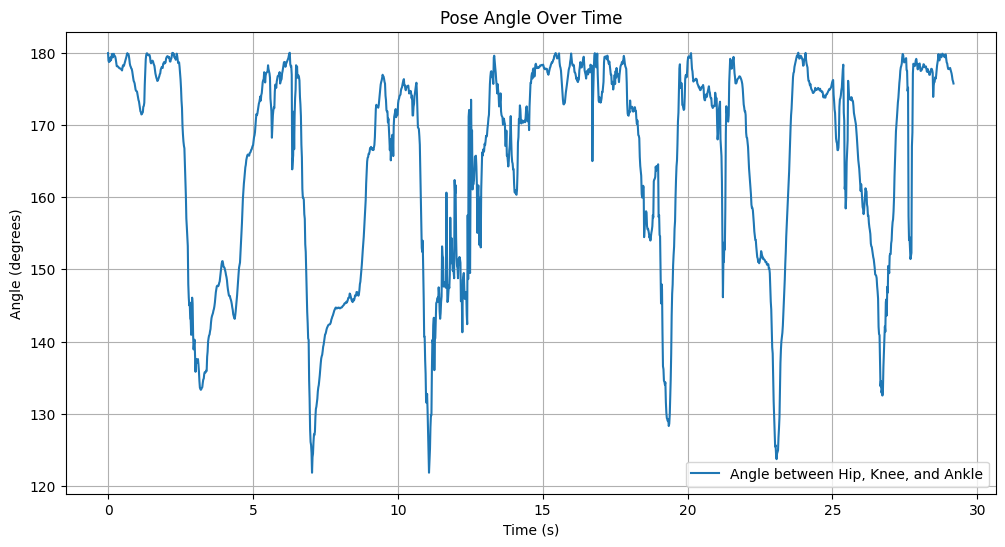

In [9]:
mp_pose=mp.solutions.pose   #initialization
pose=mp_pose.Pose()         #create a pose to performe the detection
mp_drawing = mp.solutions.drawing_utils

def calculate_angle(a, b, c):
    ab = np.array(a) - np.array(b)
    bc = np.array(c) - np.array(b)
    cos_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc)) #cos(theta)=ab.bc/(|ab|.|bc|)
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0))) # angle=degree(theta) or arccos(cos(theta))
    return angle

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    angles=[]
    frame_times=[]

    #To create  a new video with landmarks
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter('output_pose.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    while cap.isOpened():
        ret,frame = cap.read()# ret has boolean value of frame is retrieved or not.
        if not ret:
            break  # break when end of the loop.

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # open cv default data extraction has bgr so to preprocees we need to convert it rgb
        results = pose.process(rgb_frame)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark # get landmarks

            mp_drawing.draw_landmarks(
              rgb_frame,
              results.pose_landmarks,
              mp_pose.POSE_CONNECTIONS)
            out.write(rgb_frame)
            left_hip = (landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y)   # tuple vallue of x and y cordinates
            left_knee = (landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y)
            left_ankle = (landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y)

            angle = calculate_angle(left_hip, left_knee, left_ankle)
            angles.append(angle)
            frame_times.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0)

    cap.release()
    out.release()
    files.download('output_pose.mp4')
    return frame_times, angles

def plot_angles(frame_times, angles):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_times, angles, label='Angle between Hip, Knee, and Ankle')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.title('Pose Angle Over Time')   # basic plotting function
    plt.legend()
    plt.grid()

video_path = '/content/video.mp4'
frame_times, angles = process_video(video_path)
plot_angles(frame_times, angles)
